# Utilizing Trained GPT word Embeddings for classification.

### prerequisite

1. [Training GPT](https://github.com/huggingface/transformers/tree/master/examples)

2. [Training Sentencepiece](https://github.com/google/sentencepiece)

In [1]:
import torch
import torchtext
import numpy as np
import sentencepiece as spm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import sklearn

In [ ]:
embeddings = torch.load("gpt_model.pt") # load the saved gpt trained model
embeddings =  embeddings["transformer.tokens_embed.weight"].cpu().numpy() # get the embedding layer

In [2]:
# load the sentence piece model since using sentence piece makes our model and problem language agnostic
sp = spm.SentencePieceProcessor()
sp.load("SentencePiece_Tokenizer.model")

True

In [3]:
def get_token_vector(sent):
    """This methods returns the embedding of a specific token by performing a lookup
    """
    return embeddings[sp.encode_as_ids(sent)]

Suppose In a sentence we have 8 words so when use `get_token_vector` method we will get 8 vectors. To perform classification we need a fixed length sentence vector for that we use 3 different strategy to generate sentence vector.

1. Mean - Take mean of all 8 word vectors
2. Max - Take Max of all 8 word vectors
3. Mean-Max - compute Mean and Max of 8 vectors and concatenate it.

In [1]:
def get_sentence_vector(sent , pool_strategy="mean_max_concat"):
    """ pooling strategy
    mean,
    max,
    mean_max_concat
    """
    tokens  = get_token_vector(sent)
    if pool_strategy =="mean":
        return tokens.mean(axis=0)
    elif pool_strategy == "max":
        return tokens.max(axis=0)
    elif pool_strategy == "mean_max_concat":
        return np.concatenate([get_sentence_vector(sent,pool_s="mean"),get_sentence_vector(sent,pool_s="max")])
    

In [ ]:
df = pd.read_csv("my_sentiment_data.csv") # load your sentiment csv data
# it should have two columns text, sentiment

In [ ]:
# encode the target column.
encoder = LabelEncoder()
target = encoder.fit_transform(df.sentiment)

In [ ]:
# get sentence vector for all text inputs
input = np.vstack(df.text.apply(get_sentence_vector).values)
# create train test split
X_train, X_test, y_train, y_test  = train_test_split(input,target,test_size=0.3,stratify=target)

              precision    recall  f1-score   support

    negative       0.59      0.64      0.62      1645
     neutral       0.57      0.09      0.15       930
    positive       0.55      0.73      0.63      1953

    accuracy                           0.57      4528
   macro avg       0.57      0.49      0.46      4528
weighted avg       0.57      0.57      0.53      4528



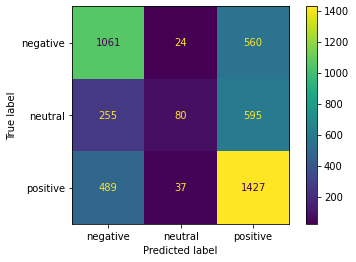

In [4]:
clf = LogisticRegression(max_iter=500).fit(X_train, y_train)

prediction = clf.predict(X_test)

print(classification_report(y_test,prediction,target_names=encoder.classes_))

sklearn.metrics.plot_confusion_matrix(clf,X_test,y_test,display_labels=encoder.classes_,values_format="d")